In [ ]:
# NOTAS:
# 10299 registos: 7352 treino+2947 teste
# 561 features
# output: 6 classes


In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut

In [2]:
import numpy as np
def report(results, n_top=3):
 for i in range(1, n_top + 1):
  candidates = np.flatnonzero(results['rank_test_score'] == i)
 for candidate in candidates:
  print("Model with rank: {0}".format(i))
  print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
  results['mean_test_score'][candidate],
  results['std_test_score'][candidate]))
  print("Parameters: {0}".format(results['params'][candidate]))
  print("")

# Import data

In [3]:
activities = pd.read_csv('C:/activity_labels.txt', sep=' ',
header=None, names=('ID','Activity'))
print(activities)

   ID            Activity
0   1             WALKING
1   2    WALKING_UPSTAIRS
2   3  WALKING_DOWNSTAIRS
3   4             SITTING
4   5            STANDING
5   6              LAYING


In [4]:
features = pd.read_csv("C:/features.txt", sep = " ",
header = None, names=('ID','Sensor'))
print(features.shape)
features.head()

(561, 2)


,ID,Sensor
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [5]:
subjects_tr = pd.read_csv("C:/subject_train.txt",
header = None, names=['SubjectID'])
subjects_tst = pd.read_csv("C:/subject_test.txt",
header = None, names=['SubjectID'])
print(subjects_tr.shape, subjects_tst.shape)
subjects_tr.head()

(7352, 1) (2947, 1)


,SubjectID
0,1
1,1
2,1
3,1
4,1


In [6]:
x_train = pd.read_csv("C:/X_train.txt",
sep = "\s+", header = None)
x_test = pd.read_csv("C:/X_test.txt",
sep = "\s+", header = None)
print(x_train.shape, x_test.shape)

(7352, 561) (2947, 561)


In [7]:
y_train = pd.read_csv("C:/y_train.txt",
header=None, names=['ActivityID'])
y_test = pd.read_csv("C:/y_test.txt",
header=None, names=['ActivityID'])
print(y_train.shape, y_test.shape)

(7352, 1) (2947, 1)


# Data preparation
* Merge training and testing datasets

In [8]:
subjects_all = pd.concat([subjects_tr, subjects_tst], ignore_index=True)
print(subjects_all.shape)
x_all = pd.concat([x_train, x_test], ignore_index=True)
print(x_all.shape)
y_all = y_train.append(y_test, ignore_index=True)
print(y_all.shape)

(10299, 1)
(10299, 561)
(10299, 1)


* Put the names of the columns of X as feature names

In [9]:
sensorNames = features['Sensor']
x_all.columns = sensorNames
x_all.head()

Sensor,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


* Replace activity codes with designation (string)

In [10]:
for i in activities['ID']:
 activity = activities[activities['ID'] == i]['Activity']
 y_all = y_all.replace({i: activity.iloc[0]})
y_all.columns = ['Activity']
#y_all.head()
y_all.tail()

,Activity
10294,WALKING_UPSTAIRS
10295,WALKING_UPSTAIRS
10296,WALKING_UPSTAIRS
10297,WALKING_UPSTAIRS
10298,WALKING_UPSTAIRS


* Put everything together in a single DataFrame and save it in a CSV

In [11]:
x_all = pd.concat([x_all, subjects_all], axis=1)
allXy = pd.concat([x_all, y_all], axis=1)
print(allXy.shape)
allXy.to_csv("C:/UCI HAR Dataset/HAR_clean.csv")
allXy.head()

(10299, 563)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",SubjectID,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


# Data aggregation

* Create an aggregated dataset by individual and by activity

In [12]:
import numpy as np
grouped = allXy.groupby(['Activity']).aggregate(np.mean)
print(grouped.shape)
grouped.to_csv("C:/HAR_grouped.csv")
grouped.head()

(6, 562)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",SubjectID
Activity,,,,,,,,,,,,,,,,,,,,,
LAYING,0.268649,-0.018318,-0.107436,-0.960932,-0.943507,-0.948069,-0.963395,-0.944099,-0.947261,-0.911610,...,-0.342490,-0.658640,0.010366,0.016013,0.022788,0.009191,0.520261,-0.435944,-0.427749,16.643519
SITTING,0.273060,-0.012690,-0.105517,-0.983446,-0.934881,-0.938982,-0.985280,-0.934798,-0.936671,-0.926703,...,-0.384740,-0.686795,0.012034,0.002458,0.013413,-0.033260,-0.706042,0.006140,-0.089532,16.680360
STANDING,0.279153,-0.016152,-0.106587,-0.984435,-0.932509,-0.939914,-0.987205,-0.933875,-0.937739,-0.921265,...,-0.343769,-0.654989,0.006991,0.010397,0.004614,0.015957,-0.774143,0.209818,0.031743,16.513116
WALKING,0.276337,-0.017907,-0.108882,-0.314644,-0.023583,-0.273921,-0.352470,-0.055491,-0.274098,-0.113458,...,-0.071308,-0.400268,0.014918,-0.007011,0.011332,-0.019443,-0.761886,0.218599,0.059771,15.272938
WALKING_DOWNSTAIRS,0.288137,-0.016312,-0.105762,0.100766,0.059549,-0.190805,0.032426,0.003907,-0.214569,0.417152,...,-0.277020,-0.618394,-0.039692,-0.018665,0.203588,-0.076029,-0.780873,0.200189,0.055866,15.828592


# Data exploration
* Check for null values

In [13]:
allXy.isnull().sum().sum()

0

* Characterize distribution of the output variable

In [14]:
allXy.groupby("Activity").size()
grouped.groupby("Activity").size()

Activity
LAYING                1
SITTING               1
STANDING              1
WALKING               1
WALKING_DOWNSTAIRS    1
WALKING_UPSTAIRS      1
dtype: int64

* Characterize distribution of input variables

In [15]:
allXy.iloc[:,:-2].mean()

tBodyAcc-mean()-X                       0.274347
tBodyAcc-mean()-Y                      -0.017743
tBodyAcc-mean()-Z                      -0.108925
tBodyAcc-std()-X                       -0.607784
tBodyAcc-std()-Y                       -0.510191
                                          ...   
angle(tBodyGyroMean,gravityMean)        0.017683
angle(tBodyGyroJerkMean,gravityMean)   -0.009219
angle(X,gravityMean)                   -0.496522
angle(Y,gravityMean)                    0.063255
angle(Z,gravityMean)                   -0.054284
Length: 561, dtype: float64

In [16]:
allXy.iloc[:,:-2].max()

tBodyAcc-mean()-X                       1.0
tBodyAcc-mean()-Y                       1.0
tBodyAcc-mean()-Z                       1.0
tBodyAcc-std()-X                        1.0
tBodyAcc-std()-Y                        1.0
                                       ... 
angle(tBodyGyroMean,gravityMean)        1.0
angle(tBodyGyroJerkMean,gravityMean)    1.0
angle(X,gravityMean)                    1.0
angle(Y,gravityMean)                    1.0
angle(Z,gravityMean)                    1.0
Length: 561, dtype: float64

In [17]:
allXy.iloc[:,:-2].min()

tBodyAcc-mean()-X                      -1.0
tBodyAcc-mean()-Y                      -1.0
tBodyAcc-mean()-Z                      -1.0
tBodyAcc-std()-X                       -1.0
tBodyAcc-std()-Y                       -1.0
                                       ... 
angle(tBodyGyroMean,gravityMean)       -1.0
angle(tBodyGyroJerkMean,gravityMean)   -1.0
angle(X,gravityMean)                   -1.0
angle(Y,gravityMean)                   -1.0
angle(Z,gravityMean)                   -1.0
Length: 561, dtype: float64

In [18]:
allXy.iloc[:,:-2].std()

tBodyAcc-mean()-X                       0.067628
tBodyAcc-mean()-Y                       0.037128
tBodyAcc-mean()-Z                       0.053033
tBodyAcc-std()-X                        0.438694
tBodyAcc-std()-Y                        0.500240
                                          ...   
angle(tBodyGyroMean,gravityMean)        0.616188
angle(tBodyGyroJerkMean,gravityMean)    0.484770
angle(X,gravityMean)                    0.511158
angle(Y,gravityMean)                    0.305468
angle(Z,gravityMean)                    0.268898
Length: 561, dtype: float64

In [19]:
allXy.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",SubjectID
count,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,...,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000
mean,0.274347,-0.017743,-0.108925,-0.607784,-0.510191,-0.613064,-0.633593,-0.525697,-0.614989,-0.466732,...,-0.298592,-0.617700,0.007705,0.002648,0.017683,-0.009219,-0.496522,0.063255,-0.054284,16.146422
std,0.067628,0.037128,0.053033,0.438694,0.500240,0.403657,0.413333,0.484201,0.399034,0.538707,...,0.320199,0.308796,0.336591,0.447364,0.616188,0.484770,0.511158,0.305468,0.268898,8.679067
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.262625,-0.024902,-0.121019,-0.992360,-0.976990,-0.979137,-0.993293,-0.977017,-0.979064,-0.935788,...,-0.536174,-0.841847,-0.124694,-0.287031,-0.493108,-0.389041,-0.817288,0.002151,-0.131880,9.000000
50%,0.277174,-0.017162,-0.108596,-0.943030,-0.835032,-0.850773,-0.948244,-0.843670,-0.845068,-0.874825,...,-0.335160,-0.703402,0.008146,0.007668,0.017192,-0.007186,-0.715631,0.182028,-0.003882,17.000000
75%,0.288354,-0.010625,-0.097589,-0.250293,-0.057336,-0.278737,-0.302033,-0.087405,-0.288149,-0.014641,...,-0.113167,-0.487981,0.149005,0.291490,0.536137,0.365996,-0.521503,0.250790,0.102970,24.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000


# Dimensionality reduction

In [317]:
corr = allXy.corr()

In [318]:
corr

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",SubjectID
tBodyAcc-mean()-X,1.000000,0.128037,-0.230302,0.004590,-0.016785,-0.036071,0.010303,-0.017488,-0.038805,0.046943,...,-0.006179,-0.002255,-0.552989,0.015754,0.036047,0.034296,-0.041021,0.034053,0.030656,0.020345
tBodyAcc-mean()-Y,0.128037,1.000000,-0.029882,-0.046352,-0.046996,-0.054153,-0.045247,-0.047673,-0.055524,-0.039445,...,-0.000649,-0.002842,0.077750,-0.027567,0.013241,0.077627,-0.007513,-0.005616,-0.016233,-0.001577
tBodyAcc-mean()-Z,-0.230302,-0.029882,1.000000,-0.024185,-0.023745,-0.015632,-0.022872,-0.022966,-0.009577,-0.040218,...,0.023050,0.023122,0.055020,-0.042083,-0.066233,-0.030748,0.003215,-0.012986,-0.028406,0.001981
tBodyAcc-std()-X,0.004590,-0.046352,-0.024185,1.000000,0.922525,0.861910,0.998662,0.916087,0.856497,0.981226,...,0.165552,0.135171,-0.034334,-0.017096,0.027464,-0.027123,-0.374104,0.449425,0.393063,-0.061397
tBodyAcc-std()-Y,-0.016785,-0.046996,-0.023745,0.922525,1.000000,0.888259,0.918561,0.997510,0.887052,0.911137,...,0.220279,0.191164,-0.020806,-0.006605,0.001902,-0.015784,-0.381391,0.506106,0.425511,-0.094486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroJerkMean,gravityMean)",0.034296,0.077627,-0.030748,-0.027123,-0.015784,-0.012196,-0.027097,-0.013411,-0.012800,-0.030908,...,-0.013065,-0.011829,-0.027478,0.023605,-0.112454,1.000000,0.024822,-0.004582,-0.012549,0.008301
"angle(X,gravityMean)",-0.041021,-0.007513,0.003215,-0.374104,-0.381391,-0.353271,-0.371168,-0.378013,-0.355836,-0.384244,...,-0.085226,-0.081971,0.008050,0.017534,-0.007095,0.024822,1.000000,-0.748249,-0.635231,0.025003
"angle(Y,gravityMean)",0.034053,-0.005616,-0.012986,0.449425,0.506106,0.459092,0.444926,0.507947,0.460345,0.458832,...,0.087671,0.078010,0.003082,-0.007256,-0.006444,-0.004582,-0.748249,1.000000,0.545614,-0.024190
"angle(Z,gravityMean)",0.030656,-0.016233,-0.028406,0.393063,0.425511,0.483424,0.389481,0.424479,0.480032,0.402873,...,0.058759,0.054008,-0.003242,-0.013130,-0.015380,-0.012549,-0.635231,0.545614,1.000000,-0.067160


### PCA
* Standardize data

In [319]:
from sklearn import preprocessing
scaled = preprocessing.scale(allXy.iloc[:,:-2])

* PCA

In [320]:
from sklearn.decomposition import PCA
n = 10
pca = PCA(n_components=n)
pca.fit(scaled)
print(pca.components_)
X_reduced = pca.transform(scaled)

[[ 0.00032202 -0.00265502 -0.00183102 ... -0.02322551  0.028696
   0.02622314]
 [ 0.01667862  0.00050924 -0.00496277 ...  0.0248285  -0.04036438
  -0.02188039]
 [-0.03345163  0.00185355  0.0090158  ...  0.09272471 -0.06636146
  -0.0442714 ]
 ...
 [-0.07563148  0.01388375  0.03478885 ... -0.03119468  0.04829835
   0.01886985]
 [-0.07206842 -0.00524786  0.01974199 ...  0.01674543 -0.02933612
   0.00958309]
 [-0.05091365 -0.00115625  0.03978647 ...  0.03131667 -0.04949016
   0.00199879]]


* Variance explained

Var. explained: [0.50738221 0.06239186 0.02692564 0.02452871 0.01888936 0.01631395
 0.01414533 0.0121621  0.00985244 0.00949217]


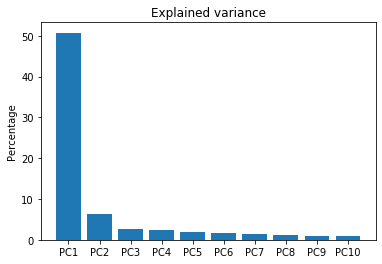

In [321]:
import matplotlib.pyplot as plt
print('Var. explained: %s'% str(pca.explained_variance_ratio_))
plt.bar(range(n), pca.explained_variance_ratio_*100)
plt.xticks(range(n), ['PC'+str(i) for i in range(1,n+1)])
plt.title("Explained variance")
plt.ylabel("Percentage")
plt.show()

* Scores plot – PC1 + PC2

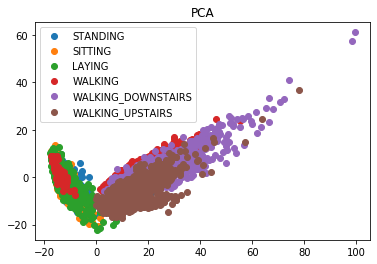

In [322]:
for act in allXy['Activity'].unique():
 sp = allXy.index[allXy['Activity']==act]-1
 plt.plot(X_reduced[sp,0],X_reduced[sp,1],'o',label=act)
plt.title("PCA")
plt.legend(loc='best', shadow=False)
plt.show()

Var. explained: [0.78571007 0.09901985 0.05655302]


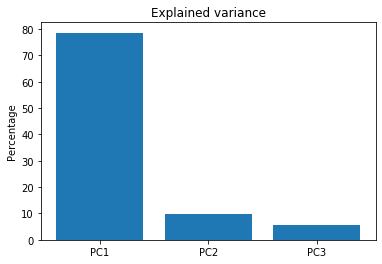

In [323]:
# dados agrupados

scaled_gp = preprocessing.scale(grouped.iloc[:,:-2])
n=3
pca_gp = PCA(n_components=n)
pca_gp.fit(scaled_gp)
X_reduced_gp = pca_gp.transform(scaled_gp)

print('Var. explained: %s'% str(pca_gp.explained_variance_ratio_))
plt.bar(range(n), pca_gp.explained_variance_ratio_*100)
plt.xticks(range(n), ['PC'+str(i) for i in range(1,n+1)])
plt.title("Explained variance")
plt.ylabel("Percentage")
plt.show()

#for act in grouped['Activity'].unique():
# sp = grouped.index[grouped['Activity']==act]-1
# plt.plot(X_reduced_gp[sp,0],X_reduced_gp[sp,1],'o',label=act)
# plt.title("PCA")
# plt.legend(loc='best', shadow=False)
# plt.show()

C:\ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


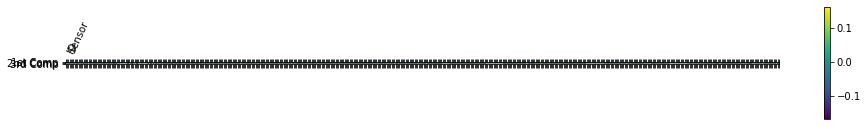

In [324]:
plt.matshow(pca.components_,cmap='viridis')
#plt.figure(figsize=(10,20))
plt.yticks([0,1,2],['1st Comp','2nd Comp','3rd Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(features)),features,rotation=65,ha='left')
plt.tight_layout()
plt.show() 

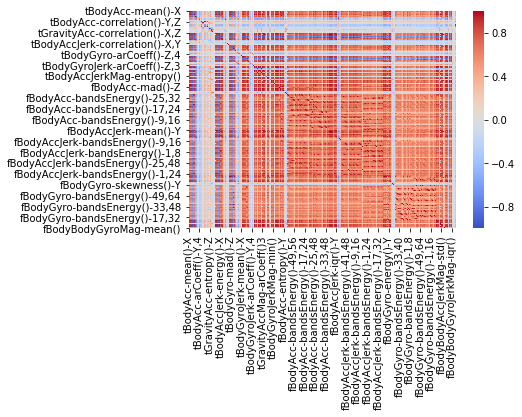

In [325]:
# em https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21
feature_worst=list(allXy[20:31]) # select the 'worst' features
#print(feature_worst)
import seaborn as sns
s=sns.heatmap(allXy[feature_worst].corr(),cmap='coolwarm') 
#s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=7)
#s.set_xticklabels(s.get_xticklabels(),rotation=30,fontsize=7)
#plt.show()

# Clustering
### K-Means Clustering

* Correr o clustering

In [326]:
from sklearn.cluster import KMeans
k=6
kmeans_har = KMeans(n_clusters=k, max_iter=1000)
kmeans_har.fit(scaled)
labels = kmeans_har.labels_
centroids = kmeans_har.cluster_centers_

* Comparar com os grupos “naturais”

In [327]:
pd.crosstab(labels, allXy["Activity"], rownames=['clusters'])

Activity,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
clusters,,,,,,
0,1556,91,0,0,0,0
1,5,1,0,903,321,1242
2,0,0,0,742,889,295
3,0,0,0,77,196,5
4,54,1238,1346,0,0,0
5,329,447,560,0,0,2


### Clustering hierárquico
* Correr o clustering (para os dados agrupados standardizados)

In [328]:
from scipy.cluster.hierarchy import dendrogram, linkage
grouped_sc = preprocessing.scale(grouped.iloc[:,2:])
Z = linkage(grouped_sc, method='single', metric='euclidean')

# Divisão treino+teste

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_all,y_all, test_size= 0.3, random_state=10)

In [40]:
from sklearn.model_selection import train_test_split
X_tr, X_ts, y_tr, y_ts = train_test_split(allXy.iloc[:,:-2],allXy.iloc[:,-1], test_size= 0.3)
print(X_tr.shape, y_tr.shape)
print(X_ts.shape, y_ts.shape)
print(y_tr.value_counts()/len(y_tr))
print(y_ts.value_counts()/len(y_ts))

(7209, 561) (7209,)
(3090, 561) (3090,)
LAYING                0.186295
STANDING              0.185185
SITTING               0.174227
WALKING               0.164933
WALKING_UPSTAIRS      0.152032
WALKING_DOWNSTAIRS    0.137328
Name: Activity, dtype: float64
LAYING                0.194498
STANDING              0.184790
WALKING               0.172492
SITTING               0.168608
WALKING_UPSTAIRS      0.144984
WALKING_DOWNSTAIRS    0.134628
Name: Activity, dtype: float64


# KNN

In [330]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1,p=1, weights='uniform')
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=1,
                     weights='uniform')

In [332]:
knn_model=knn.fit(X_train, y_train.values.ravel())
print(knn_model)
Y_pred_test = knn_model.predict(X_test)
#print('Valores previstos:',Y_pred_test)
#print('Valores reais    :',y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=1,
                     weights='uniform')


In [333]:
conf_mat=confusion_matrix(y_test,knn_model.predict(X_test))
conf_mat=pd.DataFrame(conf_mat)
#conf_mat.index.name='Actual'
#conf_mat.columns.name='Predicted'
print(conf_mat)

     0    1    2    3    4    5
0  582    0    0    0    0    0
1    0  517   21    0    0    0
2    0   13  543    0    0    0
3    0    0    0  512    0    0
4    0    0    0    0  425    1
5    0    0    0    0    0  476


In [334]:
#print('Score:',knn_model.score(X_test, y_test))
print("Accuracy_test:",metrics.accuracy_score(y_test , Y_pred_test)) 
print("Balanced_Accuracy_test:",metrics.balanced_accuracy_score(y_test , Y_pred_test)) 

Accuracy_test: 0.988673139158576
Balanced_Accuracy_test: 0.9892063049910874


### Ensamble: bagging

In [336]:
from sklearn.ensemble import BaggingClassifier

bagged_model_knn = BaggingClassifier(knn, max_samples=0.5, max_features=0.5)
scores_bag = cross_val_score(bagged_model_knn, x_all, y_all.values.ravel(), cv = 5)
print (scores_bag)
print(scores_bag.mean())

[0.88834951 0.90339806 0.92135922 0.9276699  0.90869354]
0.9098940479165586


# Random Forest

In [206]:
from sklearn.ensemble import RandomForestClassifier

In [369]:
rf_clf = RandomForestClassifier(n_estimators = 100,criterion='entropy',bootstrap=False)
rf_clf = rf_clf.fit(X_train, y_train)
print('Score:',rf_clf.score(X_test, y_test))

C:\Anaconda3b\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Score: 0.9815533980582525


In [ ]:
#entropy: 0.9770226537216828
# sem bootstrap:  0.9825242718446602

In [370]:
rf_clf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [245]:
conf_mat=confusion_matrix(y_test,rf_clf.predict(X_test))
conf_mat=pd.DataFrame(conf_mat)
conf_mat.index.name='Actual'
conf_mat.columns.name='Predicted'
print(conf_mat)

Predicted    0    1    2    3    4    5
Actual                                 
0          582    0    0    0    0    0
1            0  514   24    0    0    0
2            0   17  539    0    0    0
3            0    0    0  504    2    6
4            0    0    0    2  419    5
5            0    0    0    2    2  472


* cross validation

In [246]:
for n_estimators in [50, 100, 200, 500]:
 rf_clf = RandomForestClassifier(n_estimators = n_estimators,criterion='entropy',bootstrap=False)
 rf_scores = cross_val_score(rf_clf, x_all, y_all.values.ravel(), scoring="accuracy", cv = 4)
 print("Num estimators: %.4f Accuracy: %.4f" %(n_estimators, rf_scores.mean()))

Num estimators: 50.0000 Accuracy: 0.9389
Num estimators: 100.0000 Accuracy: 0.9406
Num estimators: 200.0000 Accuracy: 0.9422
Num estimators: 500.0000 Accuracy: 0.9412


In [248]:
rf_clf = RandomForestClassifier(n_estimators = 100,criterion='entropy',bootstrap=False)
predictions=cross_val_predict(rf_clf,x_all,y_all.values.ravel(),cv=4)

In [249]:
conf_mat=confusion_matrix(y_all,predictions)
conf_mat=pd.DataFrame(conf_mat)
conf_mat.index.name='Actual'
conf_mat.columns.name='Predicted'
print(conf_mat)

Predicted     0     1     2     3     4     5
Actual                                       
0          1941     0     0     0     2     1
1            15  1615   146     0     0     1
2             0   144  1762     0     0     0
3             0     0     0  1593    48    81
4             0     0     0    23  1326    57
5             0     0     1    46    65  1432


### Ensamble: bagging

In [337]:
bagged_model_rf = BaggingClassifier(rf_clf, max_samples=0.5, max_features=0.5)
scores_bag = cross_val_score(bagged_model_rf, x_all, y_all.values.ravel(), cv = 5)
print (scores_bag)
print(scores_bag.mean())

[0.9368932  0.92330097 0.95145631 0.95339806 0.93589121]
0.9401879506028472


In [41]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
bag_model = BaggingClassifier(tree.DecisionTreeClassifier())
bag_model.fit(X_tr, y_tr)
bag_model.score(X_ts, y_ts)

0.9592233009708738

### Ensamble: boosting
(converting a set of weak learners into strong learners)

In [342]:
from sklearn.ensemble import AdaBoostClassifier
ada_tree = AdaBoostClassifier()
ada_tree1 = ada_tree.fit(X_train, y_train.values.ravel())
print(ada_tree1.score(X_test, y_test.values.ravel()))

0.5339805825242718


In [338]:
ada_tree = AdaBoostClassifier(n_estimators=100)
scores_ada = cross_val_score(ada_tree, x_all, y_all.values.ravel(), cv = 4)
print (scores_ada)
print (scores_ada.mean())

[0.54058252 0.54097087 0.54058252 0.54118104]
0.5408292408777845


In [351]:
ada_tree = AdaBoostClassifier(n_estimators=100)
ada_tree.fit(X_train,y_train.values.ravel())
print('Score:',ada_tree.score(X_test, y_test.values.ravel()))

Score: 0.5339805825242718


In [355]:
# XGBoost 
from xgboost import XGBClassifier
clf = XGBClassifier()
X_train = X_train.loc[:,~X_train.columns.duplicated()]
# n_estimators = 100 (default)
# max_depth = 3 (default)
clf.fit(X_train,y_train.values.ravel())
#clf.predict(x_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [356]:
X_test = X_test.loc[:,~X_test.columns.duplicated()]
print('Score:',clf.score(X_test, y_test.values.ravel()))

Score: 0.9802588996763754


# SVM

In [25]:
from sklearn import svm

In [28]:
svm_model = svm.SVC(kernel='linear', C=20, gamma=0.01, random_state=123)
svm_model=svm_model.fit(X_train, y_train.values.ravel())
print('Score:',svm_model.score(X_test, y_test.values.ravel()))

Score: 0.9851132686084142


In [27]:
#C1+G0.1: 0.9828478964401295
#C10+G0.1: 0.984789644012945
#C20+G0.1:  0.9851132686084142

In [29]:
svm_model

SVC(C=20, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=123, shrinking=True, tol=0.001,
    verbose=False)

In [360]:
conf_mat=confusion_matrix(y_test,svm_model.predict(X_test))
conf_mat=pd.DataFrame(conf_mat)
conf_mat.index.name='Actual'
conf_mat.columns.name='Predicted'
print(conf_mat)

Predicted    0    1    2    3    4    5
Actual                                 
0          582    0    0    0    0    0
1            0  513   25    0    0    0
2            0   17  539    0    0    0
3            0    0    0  512    0    0
4            0    0    0    0  426    0
5            0    0    0    4    0  472


### Cross validation
* Scoring: accuracy

In [289]:
svm_cv = cross_val_score(svm_model, x_all, y_all.values.ravel(), cv = 4, scoring="accuracy")
print('Score mean:',svm_cv.mean())

Score mean: 0.9585396911610504


In [290]:
predictions=cross_val_predict(svm_model,x_all,y_all.values.ravel(),cv=4)
conf_mat=confusion_matrix(y_all,predictions)
conf_mat=pd.DataFrame(conf_mat)
conf_mat.index.name='Actual'
conf_mat.columns.name='Predicted'
print(conf_mat)

Predicted     0     1     2     3     4     5
Actual                                       
0          1944     0     0     0     0     0
1             2  1653   120     0     0     2
2             0   145  1761     0     0     0
3             0     0     0  1666     9    47
4             0     0     0    19  1378     9
5             0     0     0    20    54  1470


# Otimização de hiperpârametros
### Procura em grelha de parâmetros de SVMs 

In [367]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
#parameters = {'kernel':('linear', 'sigmoid', 'rbf', 'poly','precomputed'), 'C':[1, 10, 20, 100],'gamma':[0.01, 0.001]}
parameters = {'kernel':('linear','rbf'), 'C':[1,20],'gamma':[0.01,0.001]}
svm_model_d = svm.SVC( )

# GridSearch
opt_model_d = GridSearchCV(svm_model_d, parameters)
opt_model_d.fit(x_all, y_all.values.ravel())
print (opt_model_d.best_estimator_)
scores_gs = cross_val_score(opt_model_d, x_all, y_all.values.ravel(), cv = 5)
print (scores_gs.mean())

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
0.9597057672449157


### Seleção aleatória

In [368]:
# seleção aleatória
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100)
param_dist = {"max_depth": [2, 3, None], "max_features": [2,4,6],"min_samples_split": [2,4,6], "min_samples_leaf": [2,4,6],
"bootstrap": [True, False], "criterion": ["gini", "entropy"]}

rand_search =  (rf_model,param_distributions=param_dist, n_iter=20, cv = 5)
rand_search.fit(x_all, y_all.values.ravel())
print (rand_search.best_estimator_)
report(rand_search.cv_results_)
scores_rs = cross_val_score(rand_search, x_all, y_all.values.ravel(), cv = 5)
print ('Score mean:',scores_rs.mean())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Model with rank: 3
Mean validation score: 0.928 (std: 0.013)
Parameters: {'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 4, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}

Score mean: 0.9337798535437599


In [ ]:

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Grid search; SVM com kernel Gaussiano

In [47]:
from sklearn.model_selection import GridSearchCV
parameters = {'C':[1, 10, 100], 'gamma':[0.01, 0.001]}
svm_model_d = svm.SVC()
opt_model_d = GridSearchCV(svm_model_d, parameters)
opt_model_d.fit(X_tr, y_tr)
print (opt_model_d.best_estimator_)
opt_model_d.score(X_ts, y_ts)
opt_model_d.fit(allXy.iloc[:,:-2], allXy.iloc[:,-1])

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'gamma': [0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

* Modelo final

In [48]:
opt_model_d.fit(allXy.iloc[:,:-2], allXy.iloc[:,-1])

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'gamma': [0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [51]:
print (opt_model_d.best_estimator_)
report(opt_model_d.cv_results_)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Model with rank: 3
Mean validation score: 0.960 (std: 0.014)
Parameters: {'C': 100, 'gamma': 0.001}



# Seleção de atributos/Feature selection
### Remover variáveis cuja variabilidade seja inferior ao treshold [não supervisionada]


In [30]:
from sklearn import datasets, svm
from sklearn.feature_selection import VarianceThreshold
print (x_all.shape)
sel = VarianceThreshold(threshold=0.10)
filt = sel.fit_transform(x_all)
print (filt.shape)
svm_model = svm.SVC(gamma=0.01, C=10, kernel='linear')

(10299, 562)
(10299, 184)


In [31]:
scores= cross_val_score(svm_model, x_all, y_all.values.ravel(), cv= 5)
print (scores.mean())
scores_vt= cross_val_score(svm_model, filt, y_all.values.ravel(), cv= 5)
print (scores_vt.mean())
#com 1/3 variáveis conseguimos um score 0,95 (proximo de .96)

0.9580553761133928
0.9467922499846754


In [391]:
from sklearn import datasets, svm
from sklearn.feature_selection import VarianceThreshold
print (x_all.shape)
sel = VarianceThreshold(threshold=0.30)
filt = sel.fit_transform(x_all)
print (filt.shape)
svm_model = svm.SVC(gamma=0.01, C=10, kernel='linear')

(10299, 562)
(10299, 28)


In [392]:
scores= cross_val_score(svm_model, x_all, y_all.values.ravel(), cv= 5)
print (scores.mean())
scores_vt= cross_val_score(svm_model, filt, y_all.values.ravel(), cv= 5)
print (scores_vt.mean())
#com 28 variáveis (5%) conseguimos um score 0,88 (proximo de .96)

0.9580553761133928
0.8766877596344724


In [44]:
# sugestão professor
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.05)
filt_var = sel.fit_transform(allXy.iloc[:,:-2])
print(filt_var .shape)
X_tr_f, X_ts_f, y_tr_f, y_ts_f = train_test_split(filt_var,allXy.iloc[:,-1], test_size= 0.3)
svm_model.fit(X_tr_f, y_tr_f)
svm_model.score(X_ts_f, y_ts_f)

(10299, 364)


0.9857605177993527

### Seleção Algoritmos de filtragem supervisiona
#### Apenas com um input, como discriminar o output

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
#usa qui quadrado
filt_kb = SelectKBest(chi2, k=100).fit_transform(x_all, y_all.values.ravel())
#print (filt_kb.shape)
#scores_kb = cross_val_score(svm_model, filt_kb, y_all.values.ravel(), cv = 5)
#print (scores_kb.mean())

## Não pode ser usado com valores de input<0

In [405]:
#usa f class test
# parar quando chegar a 100 das 562 variáveis de input
filt_kb2 = SelectKBest(f_classif, k=100).fit_transform(x_all, y_all.values.ravel())
scores_kb2 = cross_val_score(svm_model, filt_kb2, y_all.values.ravel(), cv = 5)
print (scores_kb2.mean())

0.9226157952064581


### Wrapper: recursive feature elimination (RFE)

In [ ]:
# wrapper
from sklearn.feature_selection import RFE
svm_model = svm.SVC(kernel = "linear", C=10)
rfe = RFE(estimator=svm_model, n_features_to_select=100, step=1)
scores_rfe = cross_val_score(rfe, x_all, y_all.values.ravel(), cv = 10)
print (scores_rfe.mean())

### Testes estatísticos univariados

In [33]:
from sklearn.feature_selection import SelectPercentile, f_classif
selector = SelectPercentile(f_classif, percentile=30)
filt_univ = selector.fit_transform(allXy.iloc[:,:-2], allXy.iloc[:,-1])
print(filt_univ .shape)

(10299, 168)


### Remover atributos altamente correlacionados

In [36]:
corr_matrix = allXy.iloc[:,:-2].corr()
drop_cols = []
threshold_cor = 0.9
for i in range(len(corr_matrix.columns) - 1):
 for j in range(i+1,len(corr_matrix.columns)):
  if j not in drop_cols:
   item = corr_matrix.iloc[i:(i+1), j:(j+1)]
   val = item.values
   if abs(val) >= threshold_cor:
    drop_cols.append(j)
print(drop_cols)

[4, 6, 7, 9, 12, 15, 16, 19, 83, 84, 86, 87, 89, 92, 95, 96, 99, 100, 102, 103, 104, 135, 165, 168, 175, 181, 200, 201, 202, 203, 205, 206, 207, 213, 214, 215, 216, 218, 219, 220, 226, 227, 228, 229, 231, 233, 234, 239, 244, 265, 266, 268, 269, 271, 272, 274, 280, 281, 284, 285, 287, 288, 289, 302, 310, 314, 344, 345, 347, 348, 350, 351, 353, 359, 360, 363, 364, 366, 367, 368, 389, 393, 423, 425, 429, 438, 444, 447, 502, 503, 504, 505, 507, 508, 509, 510, 515, 516, 517, 518, 520, 522, 523, 549, 10, 13, 17, 20, 90, 93, 123, 125, 126, 128, 134, 163, 166, 179, 182, 183, 184, 208, 221, 240, 241, 242, 246, 252, 257, 260, 275, 282, 316, 324, 328, 354, 428, 431, 445, 446, 528, 530, 533, 535, 536, 8, 11, 14, 18, 21, 85, 88, 101, 124, 127, 267, 270, 273, 276, 283, 338, 342, 346, 352, 424, 427, 430, 97, 361, 91, 94, 286, 349, 365, 131, 381, 330, 105, 372, 109, 113, 49, 52, 56, 558, 50, 53, 559, 51, 54, 560, 46, 59, 47, 60, 48, 61, 66, 67, 68, 70, 71, 72, 74, 75, 76, 171, 232, 259, 442, 521, 169,

In [37]:
keep = []
for i in range(len(corr_matrix.columns)):
 if i not in drop_cols:
  keep.append(i)
  orig = allXy.iloc[:,:-2]
  filt_cor = orig.iloc[:,keep]
print(filt_cor.shape)

(10299, 204)


In [45]:
X_tr_f2, X_ts_f2, y_tr_f2, y_ts_f2 = train_test_split(filt_cor,
allXy.iloc[:,-1], test_size= 0.3)
svm_model.fit(X_tr_f2, y_tr_f2)
svm_model.score(X_ts_f2, y_ts_f2)

0.9809061488673139